
Original Series Stationarity Check:
ADF Statistic: -2.7862955756763235
p-value: 0.060258169716754635
 Time series is NOT stationary. Differencing required.

After Differencing Stationarity Check:
ADF Statistic: -15.750882113052876
p-value: 1.2237472923441344e-28
 Time series is stationary.


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported inde

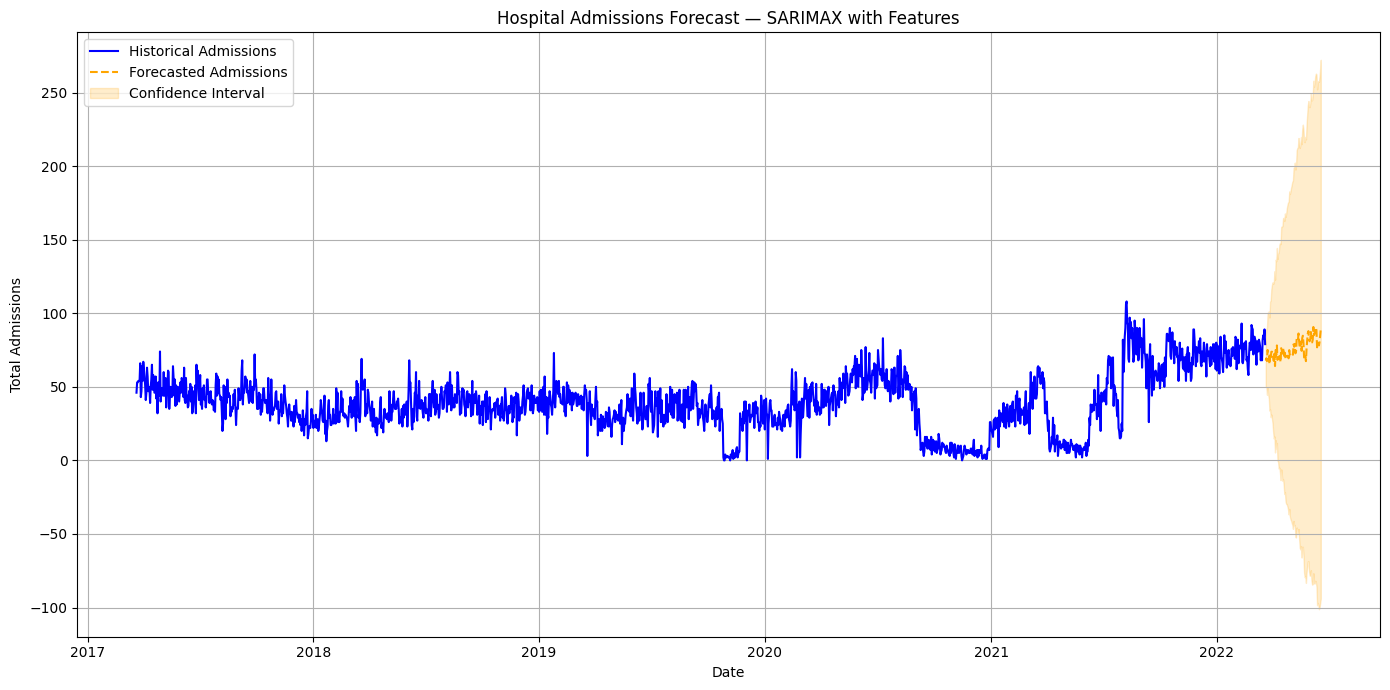


Forecast Table (first 15 rows):
     Forecast_Date  Predicted_Admissions  Lower_CI  Upper_CI
1819    2022-03-21                 67.88     50.28     85.48
1820    2022-03-22                 69.40     49.58     89.21
1821    2022-03-23                 67.49     44.59     90.38
1822    2022-03-24                 75.04     49.71    100.36
1823    2022-03-25                 72.23     44.62     99.84
1824    2022-03-26                 71.70     42.00    101.40
1825    2022-03-27                 65.40     33.74     97.06
1826    2022-03-28                 71.36     34.72    108.00
1827    2022-03-29                 68.92     29.39    108.44
1828    2022-03-30                 73.75     31.17    116.34
1829    2022-03-31                 73.87     28.53    119.20
1830    2022-04-01                 73.10     25.14    121.05
1831    2022-04-02                 69.66     19.23    120.10
1832    2022-04-03                 67.62     14.82    120.42
1833    2022-04-04                 72.43     16.34  

c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 7.11
Mean Squared Error (MSE): 87.95
Root Mean Squared Error (RMSE): 9.38


c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TottaraDhanush\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Load data
hospital_data = pd.read_csv("/finalproject/feature_engineering/time_series_data.csv")
hospital_data['ResidentDate'] = pd.to_datetime(hospital_data['ResidentDate'])
hospital_data.set_index('ResidentDate', inplace=True)
 
# Target variable
y = hospital_data['Total_Admissions']
 
# Exogenous variables — meaningful drivers of spikes
exog_vars = [
    'Total_Admissions_Rolling_Max','Total_Admissions_Rolling_Min','Total_Admissions_Rolling_Std',
        'Total_Admissions_MA14','ResidentDate_weekday','temperature_max','temperature_min',
        'Total_Admissions_Lag7','precipitation','temp_range'
]    
exog = hospital_data[exog_vars]
 
# Stationarity check
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print(" Time series is stationary.")
    else:
        print(" Time series is NOT stationary. Differencing required.")
 
print("\nOriginal Series Stationarity Check:")
test_stationarity(y)
 
# If needed, differencing:
y_diff = y.diff().dropna()
print("\nAfter Differencing Stationarity Check:")
test_stationarity(y_diff)
 
# SARIMAX model — using your external features
p, d, q = 1, 1, 1  # basic ARIMA part
P, D, Q, m = 1, 1, 1, 7  # seasonal part, weekly cycles
 
model = SARIMAX(y,
                exog=exog,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)
 
results = model.fit(disp=False)
 
# Forecasting next 90 days
future_exog = exog.iloc[-90:].copy()  # reuse last known conditions for forecasting
 
forecast_steps = 90
forecast = results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
 
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plotting the historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Historical Admissions', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecasted Admissions', color='orange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.2, label='Confidence Interval')
 
plt.title('Hospital Admissions Forecast — SARIMAX with Features')
plt.xlabel('Date')
plt.ylabel('Total Admissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 
# Print Forecast Summary
forecast_df = pd.DataFrame({
    'Forecast_Date': forecast_index,
    'Predicted_Admissions': forecast_mean.round(2),
    'Lower_CI': forecast_ci.iloc[:, 0].round(2),
    'Upper_CI': forecast_ci.iloc[:, 1].round(2)
})
print("\nForecast Table (first 15 rows):")
print(forecast_df.head(15))


# === Step 8: Calculate Performance Metrics ===
# For performance metrics, we need to split the data into training and testing sets
train_size = int(len(hospital_data) * 0.8)  # 80% for training
train, test = hospital_data.iloc[:train_size], hospital_data.iloc[train_size:]

# Define target and exogenous variables for training and testing
y_train = train['Total_Admissions']
y_test = test['Total_Admissions']
exog_train = train[exog_vars]
exog_test = test[exog_vars]

# Fit the ARIMAX model on the training data
arimax_model = SARIMAX(y_train, exog=exog_train, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
arimax_results = arimax_model.fit(disp=False)

# Forecast on the test set
forecast = arimax_results.get_forecast(steps=len(y_test), exog=exog_test)
forecast_mean = forecast.predicted_mean

# Calculate performance metrics
mae = mean_absolute_error(y_test, forecast_mean)
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

